# Third actor-critic model - edge features

In this third model, I will now include edge features (just the distance between nodes for now) and covolve over both nodes and edges in the actor/critic networks. Hopefully, in this way, the networks will be able to perform computations on the edges in order to compare distances, etc. I will also use a different action representation - instead of sorting action values along a 1D interval, I will embed the actions in a complex space $a = \rho e^{i\theta} \in \mathbb{C}$, and determine the visitation order by the angle/argument $\theta$ around the origin. In this way, the periodicity of the traveling salesman tour is manifest, and is invariant under the arbitrary choice of "beginning" and "end".

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/ecotner/neural_tsp/notebooks/training

/home/ecotner/neural_tsp/notebooks/training


In [3]:
import time
import datetime as dt
import random

import torch
import torch.tensor as tt
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import networkx as nx

from neuraltsp.environments import RandomTSPEnv
from neuraltsp.models.actor_critic_03 import Actor, Critic

In [4]:
# initialize GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


I'm going to use a randomly-generated set of TSP problems to solve, where each one will have a random number of stops between 10 and 20.

In [5]:
env = RandomTSPEnv(n_locs=list(range(10, 21)))

In [6]:
# Initialize policy/value network
actor = Actor()
critic = Critic()
actor.to(device);
critic.to(device);

In [32]:
# Initialize optimizer
lr = 3e-6
val_optimizer = optim.SGD(params=critic.parameters(), lr=lr, momentum=0.99)
actor_optimizer = optim.SGD(params=actor.parameters(), lr=lr, momentum=0.99)

In [33]:
# Log training loss, reward, etc.
with open("train.log", "w+") as fp:
    fp.write("loss,reward,q_value")

In order to encourage exploration, a random permuation of the locations is chosen with probability equal to the fraction of time left in the training loop. We run this for 20 minutes and save the critic loss, reward, and Q-value at each step:

In [7]:
def state_to_graph_matrices(s):
    N = s.locs.shape[0]
    G = nx.DiGraph(s.dmatrix.cpu().numpy())
    # normalized adjacency matrix
    A = torch.ones(N, N, device=device, dtype=torch.float) / N
    # normalized incidence matrix
    B = tt(nx.incidence_matrix(G, oriented=True).T.todense(), device=device, dtype=torch.float) / (N-1)
    # node features
    V = s.locs.reshape(1, -1, 2).type(torch.float).to(device)
    # edge features
    E = nx.incidence_matrix(G, oriented=True, weight="weight").T.todense().max(axis=-1)
    E = tt(E, device=device, dtype=torch.float).reshape(1, -1, 1)
    return N, A, B, V, E

In [37]:
max_time = 60*60
tic = time.time()
episode = 0
with open("train.log", "a") as fp, tqdm.tqdm() as pbar:
    # while time.time() - tic < max_time:
    while dt.datetime.now() < dt.datetime(2020, 10, 21, 8, 0, 0):
        # Reset environment and get state -> convert to A, V
        s = env.reset()
        N, A, B, V, E = state_to_graph_matrices(s)
        # Take action and update state
        a = actor(A, B, V, E)
        # Add random noise occasionally
        eps = (time.time() - tic)/max_time
        eps = (1 - 0.025)*np.exp(-eps/0.25) + 0.025
        if random.random() < eps:
            a = a[..., torch.randperm(N), :]
        Q = critic(A, B, V, E, a)
        # Turn the vector into a sequence of stops by doing argsort on
        # the angle around the origin
        a = torch.atan2(a[...,1], a[...,0]).argsort().squeeze()
        s, r, _, _ = env.step(a, kind="re-order")
        # Update actor
        actor_optimizer.zero_grad()
        loss = -Q
        loss.backward(retain_graph=True)
        actor_optimizer.step()
        q_val = -loss.data.cpu().numpy()
        # Update critic
        val_optimizer.zero_grad()
        loss = torch.pow(r - Q, 2)
        loss.backward()
        val_optimizer.step()
        loss_val = loss.data.cpu().numpy()
        fp.write(f"\n{loss_val},{r},{q_val}")
        if episode % 100 == 99:
            pbar.n = int(time.time() - tic)
            pbar.set_description(
                f"Episode {episode+1}; "
                f"loss: {loss_val:.3f}; Q-value: {q_val:.3f}; "
                f"reward: {r:.3f}; "
                f"eps: {eps:.3f}"
            )
        episode += 1

Episode 2741400; loss: 0.767; Q-value: -20.075; reward: -20.951; eps: 0.025: : 27252it [7:34:12,  1.00s/it]


In [38]:
torch.save(actor, "03_actor.torch")
torch.save(critic, "03_critic.torch")

In [9]:
actor = torch.load("03_actor.torch")
critic = torch.load("03_critic.torch")

Ok, so the agent did actually learn a coherent policy! Unfortunately it's incredibly simplistic: the agent has picked some (I assume arbitrary) vector in the 2D plane the locations lie within (looks to be about north-west), and the visitation order is determined simply by the projection of the stop locations onto this vector:

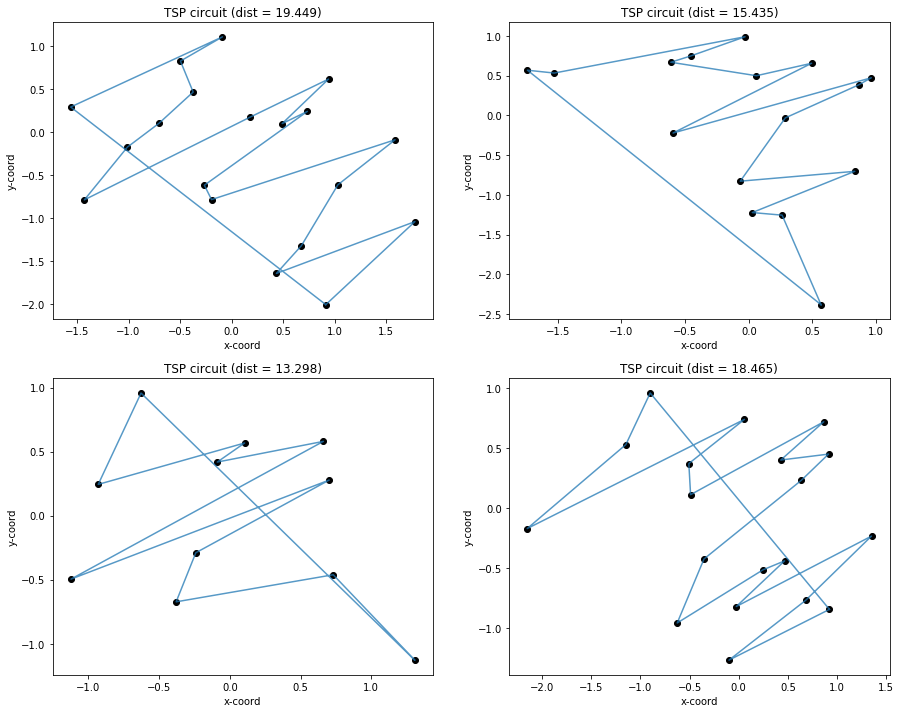

In [42]:
_, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))
for ax in axes.flatten():
    plt.sca(ax)
    s = env.reset()
    N, A, V, B, E = state_to_graph_matrices(s)
    # Take action and update state
    a = actor(A, V, B, E)
    Q = critic(A, V, B, E, a)
    # Turn the ordered vector into a sequence of stops
    a = torch.atan2(a[...,1], a[...,0]).squeeze().argsort()
    s, r, _, _ = env.step(a, kind="re-order")
    env.render()
plt.show()

It's not the _worst_ policy in the world, and it's actually quite a bit better than the previous policy of clustering nearby locations together, but without regard to other clusters. Let's also take a look directly at the 2D action representation learned by the actor:

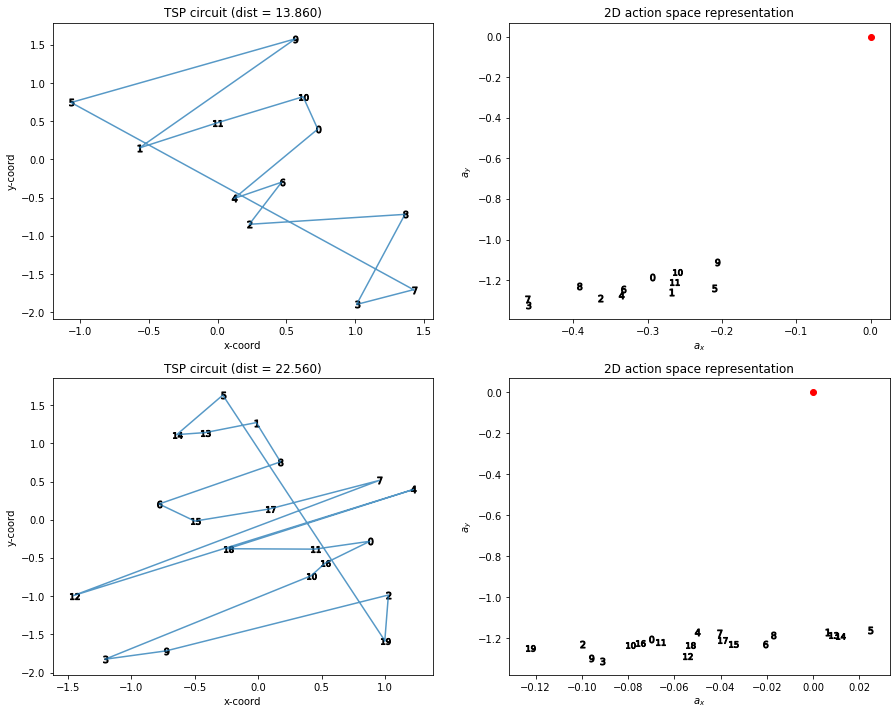

In [41]:
_, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))
for ax1, ax2 in axes:
    s = env.reset()
    N, A, V, B, E = state_to_graph_matrices(s)
    a = actor(A, V, B, E).squeeze()
    seq = torch.atan2(a[...,1], a[...,0]).argsort().squeeze()
    env.step(seq, kind="re-order")
    plt.sca(ax1)
    env.render(label_pts=True)
    plt.sca(ax2)
    for n, xy in enumerate(a.detach().cpu().numpy()):
        plt.scatter(*xy, marker=fr"${{{n}}}$", color="black", s=50*len(str(n)))
    plt.scatter(0, 0, color="red")
    plt.xlabel(r"$a_x$")
    plt.ylabel(r"$a_y$")
    plt.title("2D action space representation")
plt.show()

It seems from the ouput of the action space that despite the intent to use the angle around the origin to determine the visitation order, the action coordinates seem to cluster far away from the origin, so that the ordering is approximately linear along the direction tangent to the circle with radius equal to the dispacement vector of the "center of mass" of the action values:
$$r = \left[\sum_{j=1}^2 \left(\frac{1}{|V|} \sum_{i=1}^{|V|} a_{ij}\right)^2\right]^{1/2}$$
Perhaps it might be better to redefine the visitation order by the angle around the center of mass, thereby avoiding the difficulties involved in drifting away from the origin of the action space, so that that (arbitrary) reference point is not needed.

In [43]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [44]:
train_df = pd.read_csv("train.log")
size = len(train_df)
print(f"{size} rows/episodes")
train_df.tail()

2744522 rows/episodes


,loss,reward,q_value
2744517,11.135358,-17.194170,-13.857202
2744518,4.181830,-13.184286,-15.229239
2744519,15.153620,-26.016041,-22.123276
2744520,4.789354,-25.460457,-27.648916
2744521,14.498101,-17.619028,-13.811391


The critic seems to be doing a really good job; the Q-value tracks the reward pretty well.

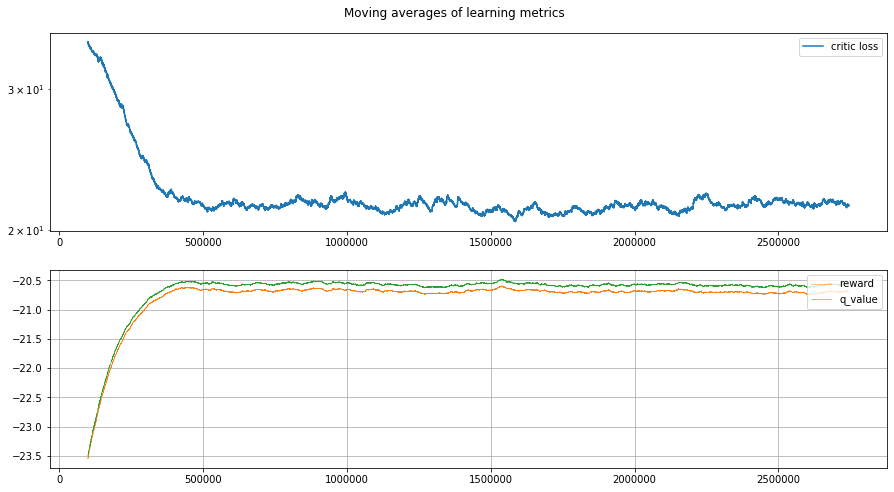

In [45]:
ma = train_df.ewm(span=len(train_df)/30).mean()
fig, axes = plt.subplots(nrows=2, figsize=(15,8))
skip = 100000

axes[0].plot(ma.iloc[skip:]['loss'], label='critic loss')
axes[0].set_yscale('log')
axes[0].legend(loc="upper right")

axes[1].plot(ma.iloc[skip:]['reward'], label='reward', color="C1", linewidth=0.5)
axes[1].plot(ma.iloc[skip:]['q_value'], label='q_value', color="C2", linewidth=0.5)
axes[1].grid()
axes[1].legend(loc="upper right")

fig.suptitle("Moving averages of learning metrics", x=0.5, y=0.925)
plt.show()

The correlation between the actual and predicted reward values is now actually quite impressive; the critic is doing a pretty good job.

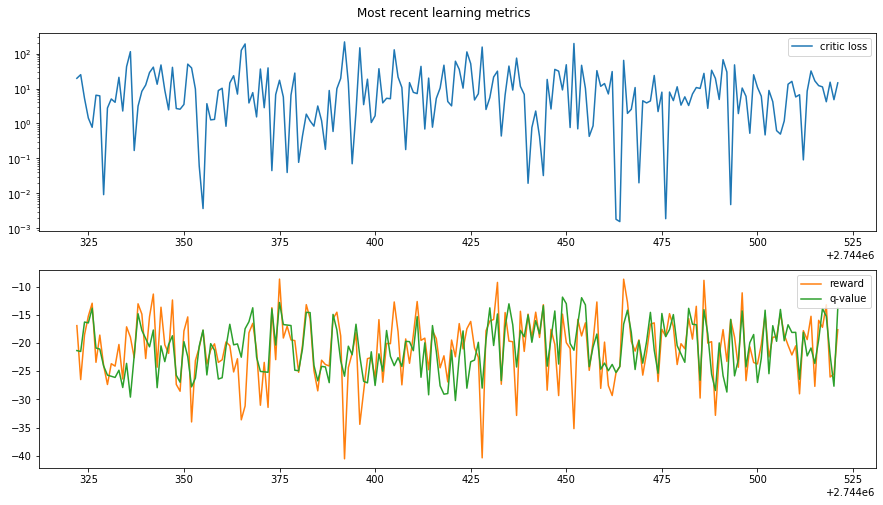

In [46]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 8))
window = 200
df = train_df.iloc[-window:]

axes[0].plot(df['loss'], label='critic loss')
axes[0].set_yscale('log')
axes[0].legend(loc="upper right")
axes[1].plot(df['reward'], label='reward', color="C1")
axes[1].plot(df['q_value'], label='q-value', color="C2")
axes[1].legend(loc="upper right")

fig.suptitle("Most recent learning metrics", x=0.5, y=0.925)
plt.show()

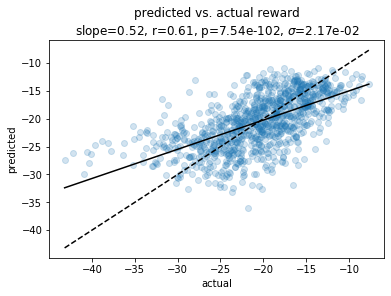

In [48]:
window = 1000
x = train_df.iloc[-window:]['reward'].values
y = train_df.iloc[-window:]['q_value'].values
plt.scatter(x, y, alpha=1/5)
m, b, r, p, s = stats.linregress(x, y)
x = np.linspace(x.min(), x.max(), 3)
y = m*x + b
plt.plot(x, y, linestyle="-", color="black", label="regression")
plt.plot(x, x, linestyle="--", color="black", label="equality")
plt.title(f"predicted vs. actual reward\nslope={m:.2f}, r={r:.2f}, p={p:.2e}, $\sigma$={s:.2e}")
plt.xlabel('actual')
plt.ylabel('predicted')
plt.show()

It seems that the agent is using the (x, y) coordinates of the stops as a crutch to create a simplistic heuristic to solve the TSP. We do not want any specific coordinate system influencing the policy because in principle, the problem is rotationally (and translationally) invariant. The only thing that should matter are the distances between the stops. In light of this, it makes sense then to remove the (x, y) coordinates as node features, and instead rely only on edge features (i.e. the distance matrix).

Also, based on the observed values of the action space, we also want to try and redefine the visitation order by the angle around the "center of mass" of the actions, so that there is no external reference point to drift from.